In [36]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  
from sklearn.decomposition import PCA
import umap
import math
import io
import umap.plot
import plotly.graph_objs as go 
import plotly.io as pio 
pio.renderers.default ='iframe'

from collections import defaultdict

import math,os,sys
import warnings 
warnings.filterwarnings('ignore')

In [2]:
from mnist_dataset import MNISTDataset 
#load dataset 
data = pd.read_csv('../data/train.csv')
data = data[:1000]
#temporarly trying to overfit with less data
val_count =200

#common transformation
default_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

#split the train to val and train
dataset = MNISTDataset(data.iloc[:-val_count], default_transform)
val_dataset = MNISTDataset(data.iloc[-val_count:], default_transform)


100%|████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4758.28it/s]


In [4]:
#setup Dataloaders with pytorch dataloaders
trainloader = DataLoader(
    dataset,
    batch_size = 128*2,
    shuffle =True,
    #pin_memory = True, # for faster data transfer speed btn CPU and GPU, but will consume more system memory
    num_workers = 2,
    #prefetch_factor = 100,#to specify how many batches should be prefetched(loaded into memory[increased memory usage tho]) asynchronously in advance.

) 

# visualizing Datapoints

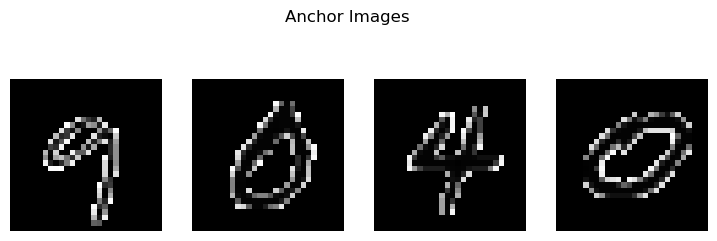

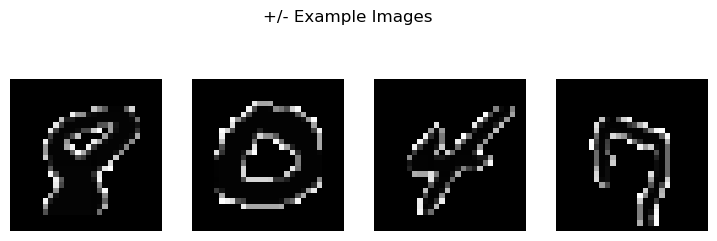

In [5]:
def show_images(images, title =''):
    num_images = len(images)
    fig,axes = plt.subplots(1, num_images,figsize=(9,3))
    for i in range(num_images):
        img = np.squeeze(images[i])
        axes[i].imshow(img,cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()
    
for batch_idx, (anchor_images, contrastive_images, distances, labels) in enumerate(trainloader):
    #converting tensors to numpy, numpy is easy to muniplate and display with matplotlib
    anchor_images = anchor_images.numpy()
    contrastive_images = contrastive_images.numpy()
    labels = labels.numpy()

    #display some imgages from batch
    show_images(anchor_images[:4], title = 'Anchor Images')
    show_images(contrastive_images[:4], title = '+/- Example Images')
    #break after displaying from one batch for demostration 
    break

# lets build Neural Network
-  Define a neural network architecture with two convolution layers and two fully connected layers
- Input to the network is an MNIST image and Output is a 64 dimensional representation. 


In [6]:
from Network import Network,Network_t ,ContrastiveLoss_with_margin
from utils import init_weights, init_weights_for_gelu

In [7]:
net = Network()

device= "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device= "mps"

#device= "cpu" #overide device for overfitting a very small data batch
net = net.to(device)

device

'mps'

### weight initialization 

In [8]:
epoch_count=10
max_lr = 6e-4
min_lr = max_lr *10 
max_steps = epoch_count
warm_up_steps = max_steps * 0.2

def get_lr(iter):
    #linear warm up for warm up steps
    if iter < warm_up_steps:
        return max_lr * (iter+1) / warm_up_steps
    #if iter > lr_decay_iters, return min learning rate
    if iter > max_steps:
        return min_lr
    #in between ,use cosine decay down to min learning rate
    decay_ratio = (iter - warm_up_steps) / (max_steps - warm_up_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) #coffe starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau,CosineAnnealingLR

In [10]:
epoch_count=10
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.00001,weight_decay=1e-5)
#optimizer = torch.optim.AdamW(net.parameters())
loss_function = ContrastiveLoss_with_margin()
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.3)
scheduler = CosineAnnealingLR(optimizer, T_max=epoch_count, eta_min=1e-6)
#scheduler reduces plateau loss
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


In [11]:
import os
checkpoint_dir ='checkpoints/'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [12]:
activations_list = []
gradients = []
#activation_metrics = defaultdict(lambda: {'tensors': []})
#custom_gain = math.sqrt(2) # Example: Adjust this value as needed
#custom_gain = nn.init.calculate_gain('relu')  # Calculate gain for ReLU


def Train_model(epoch_count=epoch_count):
    net = Network()
    net.apply(init_weights_for_gelu)
    #init_weights(net, gain=custom_gain)
    net = net.to(device)
    lrs = []
    losses = []
    activations = []
    activations_dict = {}  # Reset for each epoch
    #--------
    # Hook function to capture activations
    def get_activation(name):
        def hook(model, input, output):
            if name not in activations_dict:
                activations_dict[name] = []
            activations_dict[name].append(output.detach().cpu())
        return hook   
        
    # Register hooks for GELU layers
    for name, layer in net.named_modules():
        if isinstance(layer, nn.GELU):
            layer.register_forward_hook(get_activation(name))
   

    def capture_gradient(name):
        def hook(module, grad_input, grad_output):
            gradients.append((name, grad_output[0].detach()))
        return hook
        

    #------------
    for epoch in range(epoch_count):
        epoch_loss = 0
        batches = 0
        activations_dict = {}  # Reset for each epoch
        
        print('epoch-',epoch) 
        for param_group in optimizer.param_groups:
            lrs.append(param_group['lr'])
        
        print('learning rate',lrs[-1])

        for anchor, contrastive, distance, label in tqdm(trainloader):
            
            # Ensure data is in the correct shape
            assert anchor.shape[1] == 1, f"Expected anchor channels to be 1, but got {anchor.shape[1]}"
            assert contrastive.shape[1] == 1, f"Expected contrastive channels to be 1, but got {contrastive.shape[1]}"

            batches +=1
            optimizer.zero_grad()
            anchor_out = anchor.to(device, dtype=torch.float32)
            contrastive_out = contrastive.to(device, dtype=torch.float32)
            distance = distance.to(torch.float32).to(device)

            anchor_out = net(anchor_out)
            contrastive_out = net(contrastive_out)
            
            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss
            loss.backward()
            norm = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            optimizer.step()
        
        avg_loss = epoch_loss / batches
        
        activations_list.append(activations_dict.copy())     
        losses.append(epoch_loss.cpu().detach().numpy()/ batches)
        #scheduler.step()
        #scheduler.step(avg_loss) # for ReduceONplatea scheduler
        print('epoch_loss', losses[-1])

        #save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)

        
    # print(f"lrs = {lrs} #######")
    # print(f"losses = {losses} #####")
    print(activations_list)
    plt.plot(lrs, losses)
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate vs. Loss')
    plt.show()

    return{
        "net": net,
        "losses":losses
    }
        

In [ ]:
activations_list = []
gradients = []

def Train_model(epoch_count=epoch_count):
    net = Network()
    net.apply(init_weights_for_gelu)
    net = net.to(device)
    lrs = []
    losses = []
    activations_dict = {}  # Initialize outside the epoch loop
    
    # Hook function to capture activations
    def get_activation(name):
        def hook(model, input, output):
            if name not in activations_dict:
                activations_dict[name] = []
            activations_dict[name].append(output.detach().cpu())
        return hook   
        
    # Register hooks for GELU layers
    for name, layer in net.named_modules():
        if isinstance(layer, nn.GELU):
            layer.register_forward_hook(get_activation(name))
   

    def capture_gradient(name):
        def hook(module, grad_input, grad_output):
            gradients.append((name, grad_output[0].detach()))
        return hook
        

    for epoch in range(epoch_count):
        epoch_loss = 0
        batches = 0
        
        print('epoch-',epoch) 
        for param_group in optimizer.param_groups:
            lrs.append(param_group['lr'])
        
        print('learning rate',lrs[-1])

        for anchor, contrastive, distance, label in tqdm(trainloader):
            
            # Ensure data is in the correct shape
            assert anchor.shape[1] == 1, f"Expected anchor channels to be 1, but got {anchor.shape[1]}"
            assert contrastive.shape[1] == 1, f"Expected contrastive channels to be 1, but got {contrastive.shape[1]}"

            batches +=1
            optimizer.zero_grad()
            anchor_out = anchor.to(device, dtype=torch.float32)
            contrastive_out = contrastive.to(device, dtype=torch.float32)
            distance = distance.to(torch.float32).to(device)

            anchor_out = net(anchor_out)
            contrastive_out = net(contrastive_out)
            
            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss
            loss.backward()
            norm = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            optimizer.step()
        
        avg_loss = epoch_loss / batches
        
        activations_list.append(activations_dict.copy())  # Copy to avoid reference issues     
        losses.append(epoch_loss.cpu().detach().numpy() / batches)
        
        print('epoch_loss', losses[-1])

        # Save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)

    print(activations_list)
    plt.plot(lrs, losses)
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate vs. Loss')
    plt.show()

    return {
        "net": net,
        "losses": losses
    }


In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import defaultdict

activations_list = []
gradients = []

def Train_model(epoch_count=epoch_count):
    net = Network()
    net.apply(init_weights_for_gelu)
    net = net.to(device)
    lrs = []
    losses = []
    activations_dict = defaultdict(lambda: {'mean': [], 'var': [], 'neg_ratio': []})
    
    # Modified hook function to capture activation statistics
    def get_activation_stats(name):
        def hook(model, input, output):
            # Compute statistics
            mean = output.detach().mean().item()
            var = output.detach().var().item()
            neg_ratio = (output.detach() < 0).float().mean().item()
            
            # Store statistics
            activations_dict[name]['mean'].append(mean)
            activations_dict[name]['var'].append(var)
            activations_dict[name]['neg_ratio'].append(neg_ratio)
        return hook   
    
    # Register hooks for GELU layers (or whatever activation you're using)
    for name, layer in net.named_modules():
        if isinstance(layer, nn.GELU):  # Change this to nn.LeakyReLU if you're using Leaky ReLU
            layer.register_forward_hook(get_activation_stats(name))
   
    def capture_gradient(name):
        def hook(module, grad_input, grad_output):
            gradients.append((name, grad_output[0].detach()))
        return hook
        
    for epoch in range(epoch_count):
        epoch_loss = 0
        batches = 0
        
        print('epoch-', epoch) 
        for param_group in optimizer.param_groups:
            lrs.append(param_group['lr'])
        
        print('learning rate', lrs[-1])
        for anchor, contrastive, distance, label in tqdm(trainloader):
            
            # Ensure data is in the correct shape
            assert anchor.shape[1] == 1, f"Expected anchor channels to be 1, but got {anchor.shape[1]}"
            assert contrastive.shape[1] == 1, f"Expected contrastive channels to be 1, but got {contrastive.shape[1]}"
            batches += 1
            optimizer.zero_grad()
            anchor_out = anchor.to(device, dtype=torch.float32)
            contrastive_out = contrastive.to(device, dtype=torch.float32)
            distance = distance.to(torch.float32).to(device)
            anchor_out = net(anchor_out)
            contrastive_out = net(contrastive_out)
            
            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss
            loss.backward()
            norm = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            optimizer.step()
        
        avg_loss = epoch_loss / batches
        
        activations_list.append({k: {stat: v[stat][-batches:] for stat in v} for k, v in activations_dict.items()})
        losses.append(epoch_loss.cpu().detach().numpy() / batches)
        
        print('epoch_loss', losses[-1])
        # Save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)

    # Plot activation statistics
    plot_activation_stats(activations_list)

    # Plot learning rate vs loss
    plt.figure()
    plt.plot(lrs, losses)
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate vs. Loss')
    plt.show()

    return {
        "net": net,
        "losses": losses,
        "activations": activations_list
    }

def plot_activation_stats(activations_list):
    for layer_name in activations_list[0].keys():
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.plot([epoch[layer_name]['mean'] for epoch in activations_list])
        plt.title(f'{layer_name} - Mean Activation')
        plt.xlabel('Batch')
        plt.ylabel('Mean')

        plt.subplot(132)
        plt.plot([epoch[layer_name]['var'] for epoch in activations_list])
        plt.title(f'{layer_name} - Activation Variance')
        plt.xlabel('Batch')
        plt.ylabel('Variance')

        plt.subplot(133)
        plt.plot([epoch[layer_name]['neg_ratio'] for epoch in activations_list])
        plt.title(f'{layer_name} - Negative Activation Ratio')
        plt.xlabel('Batch')
        plt.ylabel('Ratio')

        plt.tight_layout()
        plt.show()

### redefined training for debugging plotting activations_stats

### take one

In [35]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Contrastive_learning",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "Mnist -dataset",
    "epochs": 10,
    }
)

wandb: Currently logged in as: merhawi (ajax_m). Use `wandb login --relogin` to force relogin


# take two

epoch- 0
learning rate 0.001


100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.24s/it]


epoch_loss 0.16805319488048553
epoch- 1
learning rate 0.001


100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.11s/it]


epoch_loss 0.17303253710269928
epoch- 2
learning rate 0.001


100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.32s/it]


epoch_loss 0.16595610976219177
epoch- 3
learning rate 0.001


100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.91s/it]


epoch_loss 0.17414763569831848
epoch- 4
learning rate 0.001


100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.26s/it]


epoch_loss 0.16868646442890167
epoch- 5
learning rate 0.001


100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


epoch_loss 0.16512414813041687
epoch- 6
learning rate 0.001


100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.20s/it]


epoch_loss 0.16932344436645508
epoch- 7
learning rate 0.001


100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.16s/it]


epoch_loss 0.18505781888961792
epoch- 8
learning rate 0.001


100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


epoch_loss 0.17436334490776062
epoch- 9
learning rate 0.001


100%|██████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.02s/it]


epoch_loss 0.1733807921409607
Plotting data for layer: conv1.2
Means: [[0.34473302960395813, 0.342654287815094, 0.34749794006347656, 0.33970171213150024], [0.3438809812068939, 0.34226924180984497, 0.3449113667011261, 0.3441280424594879], [0.34438714385032654, 0.34187185764312744, 0.33899858593940735, 0.3351026773452759], [0.3443497121334076, 0.34087085723876953, 0.34327003359794617, 0.3475750982761383], [0.34392228722572327, 0.3425908386707306, 0.34708037972450256, 0.3453935384750366], [0.3440379500389099, 0.3458353281021118, 0.3431815207004547, 0.3422762453556061], [0.3417426347732544, 0.3436448276042938, 0.34871265292167664, 0.3485960066318512], [0.3429037630558014, 0.34335821866989136, 0.34475743770599365, 0.33826103806495667], [0.345223605632782, 0.34276750683784485, 0.33938103914260864, 0.3450864255428314], [0.3440021574497223, 0.34183984994888306, 0.3349875211715698, 0.34148481488227844]]
Variances: [[0.376233845949173, 0.3774295449256897, 0.3747384250164032, 0.37981265783309937]

AttributeError: '_io.BytesIO' object has no attribute 'ndim'

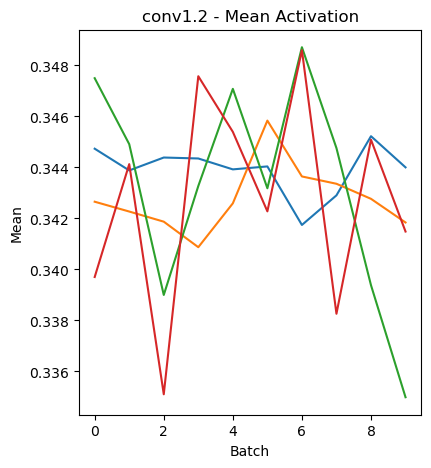

In [38]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import defaultdict
import os
from tqdm import tqdm

epoch_count=10
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.001,weight_decay=1e-5)
#optimizer = torch.optim.AdamW(net.parameters())
loss_function = ContrastiveLoss_with_margin()
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.3)
scheduler = CosineAnnealingLR(optimizer, T_max=epoch_count, eta_min=1e-6)
#scheduler reduces plateau loss
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


activations_list = []
gradients = []

def Train_model(epoch_count=10):
    net = Network()
    #The log="all" parameter tells wandb to log gradients and parameters, and 
    #log_freq=64 means it will log every 64 batches.
    wandb.watch(net, log="all", log_freq=64) 
    net.apply(init_weights_for_gelu)
    net = net.to(device)
    lrs = []
    losses = []
    activations_dict = defaultdict(lambda: {'mean': [], 'var': [], 'neg_ratio': []})
    
    def get_activation_stats(name):
        def hook(model, input, output):
            mean = output.detach().mean().item()
            var = output.detach().var().item()
            neg_ratio = (output.detach() < 0).float().mean().item()
            activations_dict[name]['mean'].append(mean)
            activations_dict[name]['var'].append(var)
            activations_dict[name]['neg_ratio'].append(neg_ratio)
            # this was not printing coz of leakyReLU wasnt correctly called(was only nn.ReLU)
            #print(f'Hook called for {name}: mean={mean}, var={var}, neg_ratio={neg_ratio}')
        return hook   
    
    # Register hooks for GELU layers (or whatever activation you're using)
    for name, layer in net.named_modules():
        if isinstance(layer, nn.LeakyReLU):
            layer.register_forward_hook(get_activation_stats(name))
            #print(f'Registered hook for layer: {name}') #-----debugging print worked
            
    def capture_gradient(name):
        def hook(module, grad_input, grad_output):
            gradients.append((name, grad_output[0].detach()))
        return hook
        
    for epoch in range(epoch_count):
        epoch_loss = 0
        batches = 0
        
        print('epoch-', epoch) 
        wandb.log({'epoch': epoch})

        for param_group in optimizer.param_groups:
            lrs.append(param_group['lr'])
        
        print('learning rate', lrs[-1])
        wandb.log({'learning rate -':lrs[-1]})
        
        for anchor, contrastive, distance, label in tqdm(trainloader):
            # assert anchor.shape[1] == 1, f"Expected anchor channels to be 1, but got {anchor.shape[1]}"
            # assert contrastive.shape[1] == 1, f"Expected contrastive channels to be 1, but got {contrastive.shape[1]}"
            batches += 1
            optimizer.zero_grad()
            anchor_out = anchor.to(device, dtype=torch.float32)
            contrastive_out = contrastive.to(device, dtype=torch.float32)
            distance = distance.to(torch.float32).to(device)
            anchor_out = net(anchor_out)
            contrastive_out = net(contrastive_out)
            
            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss
            loss.backward()
            norm = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            optimizer.step()
        
        #avg_loss = epoch_loss / batches
        
        # Debugging: Print activation statistics
        #print(f'Activations after epoch {epoch}:', {k: {stat: v[stat][-batches:] for stat in v} for k, v in activations_dict.items()})
        
        activations_list.append({k: {stat: v[stat][-batches:] for stat in v} for k, v in activations_dict.items()})
        losses.append(epoch_loss.cpu().detach().numpy() / batches)
        
        print('epoch_loss', losses[-1])
        wandb.log({'epoch_loss -': losses[-1]})
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)

    # Debugging: Print entire activations list
    #print('Final activations_list:', activations_list)

    plot_activation_stats(activations_list)

    plt.figure()
    plt.plot(lrs, losses)
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate vs. Loss')
    plt.show()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    wandb.log({"Learning Rate vs. Loss": wandb.Image(buf)})

    return {
        "net": net,
        "losses": losses,
        "activations": activations_list
    }

def plot_activation_stats(activations_list):
    if not activations_list:
        print("No activation data to plot.")
        wandb.log({'message':'No activation data to plot'})
        return

    for layer_name in activations_list[0].keys():
        means = [epoch[layer_name]['mean'] for epoch in activations_list]
        vars = [epoch[layer_name]['var'] for epoch in activations_list]
        neg_ratios = [epoch[layer_name]['neg_ratio'] for epoch in activations_list]
        
        print(f'Plotting data for layer: {layer_name}')
        wandb.log({'Plotting data for layer':layer_name})
        print(f'Means: {means}')
        wandb.log({'Means': means})
        print(f'Variances: {vars}')
        wandb.log({'Variances': vars})
        print(f'Negative Ratios: {neg_ratios}')
        wandb.log({'Negative Ratios':neg_ratios})

        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.plot(means)
        plt.title(f'{layer_name} - Mean Activation')
        plt.xlabel('Batch')
        plt.ylabel('Mean')
        
        # Log Mean Activation plot with wandb
        buf1 = io.BytesIO()
        plt.savefig(buf1, format='png')
        buf1.seek(0)
        wandb.log({f'{layer_name} - Mean Activation': wandb.Image(buf1)})

        plt.subplot(132)
        plt.plot(vars)
        plt.title(f'{layer_name} - Activation Variance')
        plt.xlabel('Batch')
        plt.ylabel('Variance')
        
        # Log Activation Variance plot
        buf2 = io.BytesIO()
        plt.savefig(buf2, format='png')
        buf2.seek(0)
        wandb.log({f'{layer_name} - Activation Variance': wandb.Image(buf2)})


        plt.subplot(133)
        plt.plot(neg_ratios)
        plt.title(f'{layer_name} - Negative Activation Ratio')
        plt.xlabel('Batch')
        plt.ylabel('Ratio')
        
        # Log Negative Activation Ratio plot
        buf3 = io.BytesIO()
        plt.savefig(buf3, format='png')
        buf3.seek(0)
        wandb.log({f'{layer_name} - Negative Activation Ratio': wandb.Image(buf3)})
        

        plt.tight_layout()
        plt.show()

        # Log the entire figure
        buf_full = io.BytesIO()
        plt.savefig(buf_full, format='png')
        buf_full.seek(0)
        wandb.log({f'{layer_name} - All Activations': wandb.Image(buf_full)})


        # Log the plot to Weights and Biases
        #wandb.log({f'{layer_name} activations': wandb.Image(buf)})

# Example usage:
# Train_model(epoch_count=10)
checkpoint_dir = 'checkpoints'


training_result = Train_model()
model = training_result["net"]
wandb.finish()

In [30]:
#this prints the class layers modules 
def print_layer_types(net):
    for name, layer in net.named_modules():
        print(f'{name}: {type(layer)}')

# Example usage:
net = Network()
print_layer_types(net)


: <class 'Network.Network'>
conv1: <class 'torch.nn.modules.container.Sequential'>
conv1.0: <class 'torch.nn.modules.conv.Conv2d'>
conv1.1: <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
conv1.2: <class 'torch.nn.modules.activation.LeakyReLU'>
conv1.3: <class 'torch.nn.modules.pooling.MaxPool2d'>
conv1.4: <class 'torch.nn.modules.dropout.Dropout'>
conv2: <class 'torch.nn.modules.container.Sequential'>
conv2.0: <class 'torch.nn.modules.conv.Conv2d'>
conv2.1: <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
conv2.2: <class 'torch.nn.modules.activation.LeakyReLU'>
conv2.3: <class 'torch.nn.modules.pooling.MaxPool2d'>
conv2.4: <class 'torch.nn.modules.dropout.Dropout'>
conv3: <class 'torch.nn.modules.container.Sequential'>
conv3.0: <class 'torch.nn.modules.conv.Conv2d'>
conv3.1: <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
conv3.2: <class 'torch.nn.modules.activation.LeakyReLU'>
conv3.3: <class 'torch.nn.modules.pooling.MaxPool2d'>
conv3.4: <class 'torch.nn.modules.dropout.Dropout'>


epoch- 0
learning rate 1e-05


  0%|          | 0/4 [00:00<?, ?it/s]

epoch_loss 0.19058915972709656
epoch- 1
learning rate 1e-05


  0%|          | 0/4 [00:00<?, ?it/s]

epoch_loss 0.17308595776557922
epoch- 2
learning rate 1e-05


  0%|          | 0/4 [00:00<?, ?it/s]

epoch_loss 0.18457815051078796
epoch- 3
learning rate 1e-05


  0%|          | 0/4 [00:00<?, ?it/s]

epoch_loss 0.18351145088672638
epoch- 4
learning rate 1e-05


  0%|          | 0/4 [00:00<?, ?it/s]

epoch_loss 0.18392661213874817
epoch- 5
learning rate 1e-05


  0%|          | 0/4 [00:00<?, ?it/s]

epoch_loss 0.1829705536365509
epoch- 6
learning rate 1e-05


  0%|          | 0/4 [00:00<?, ?it/s]

epoch_loss 0.18167845904827118
epoch- 7
learning rate 1e-05


  0%|          | 0/4 [00:00<?, ?it/s]

epoch_loss 0.19683484733104706
epoch- 8
learning rate 1e-05


  0%|          | 0/4 [00:00<?, ?it/s]

epoch_loss 0.2011934071779251
epoch- 9
learning rate 1e-05


  0%|          | 0/4 [00:00<?, ?it/s]

epoch_loss 0.1806100755929947


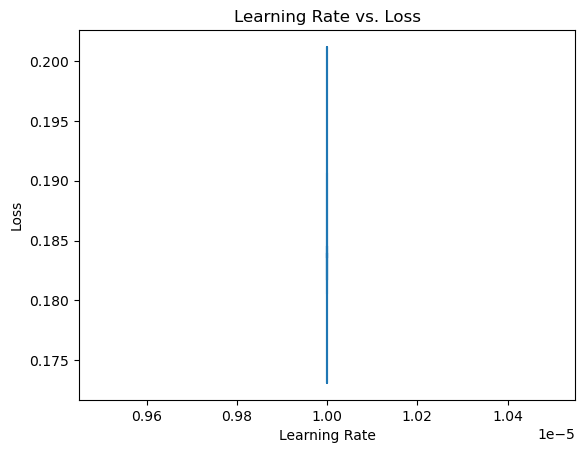

In [15]:
#train = True
checkpoint_dir = 'checkpoints'


training_result = Train_model()
model = training_result["net"]
plot_activation_stats(training_result["activations"])

# Visualize activations after training

In [16]:
def plot_activation_stats(activations_list):
    for layer_name in activations_list[0].keys():
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.plot([epoch[layer_name]['mean'] for epoch in activations_list])
        plt.title(f'{layer_name} - Mean Activation')
        plt.xlabel('Batch')
        plt.ylabel('Mean')

        plt.subplot(132)
        plt.plot([epoch[layer_name]['var'] for epoch in activations_list])
        plt.title(f'{layer_name} - Activation Variance')
        plt.xlabel('Batch')
        plt.ylabel('Variance')

        plt.subplot(133)
        plt.plot([epoch[layer_name]['neg_ratio'] for epoch in activations_list])
        plt.title(f'{layer_name} - Negative Activation Ratio')
        plt.xlabel('Batch')
        plt.ylabel('Ratio')

        plt.tight_layout()
        plt.show()
        
plot_activation_stats(training_result["activations"])
len(training_result["activations"])

10

## Debugging sessions

# initial loss estimation 

In [21]:
margin = 0.5

# Expected loss for similar pairs
expected_similar_loss = 1.0  # As (1 - score)^2 with score ≈ 0

# Expected loss for dissimilar pairs
expected_dissimilar_loss = margin ** 2  # As (score - margin)^2 with score ≈ 0

# Average the losses
initial_loss = (expected_similar_loss + expected_dissimilar_loss) / 2

print(f'Expected initial contrastive loss (cosine similarity with margin): {initial_loss}')

#--- "Expected initial contrastive loss (cosine similarity with margin): 0.625"

Expected initial contrastive loss (cosine similarity with margin): 0.625


In [17]:
if training_result["activations"]:
    print(list(training_result["activations"][0].keys()))
    for key in training_result["activations"][0].keys():
        print(f"{key}: {training_result['activations'][0][key].keys()}")
else:
    print("Activations list is empty")

[]


In [18]:
def plot_activation_stats(activations_list):
    print(f"Number of epochs: {len(activations_list)}")
    
    if not activations_list:
        print("Activations list is empty")
        return

    for layer_name in activations_list[0].keys():
        print(f"Plotting for layer: {layer_name}")
        plt.figure(figsize=(15, 5))
        
        for i, stat in enumerate(['mean', 'var', 'neg_ratio'], 1):
            plt.subplot(1, 3, i)
            values = [epoch[layer_name][stat] for epoch in activations_list]
            print(f"{stat} values: {values[:5]}...")  # Print first 5 values
            
            if not values:
                print(f"No {stat} values for {layer_name}")
                continue
            
            plt.plot(values)
            plt.title(f'{layer_name} - {stat.capitalize()}')
            plt.xlabel('Batch')
            plt.ylabel(stat.capitalize())
        
        plt.tight_layout()
        plt.show()

plot_activation_stats(training_result["activations"])

Number of epochs: 10


[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}]


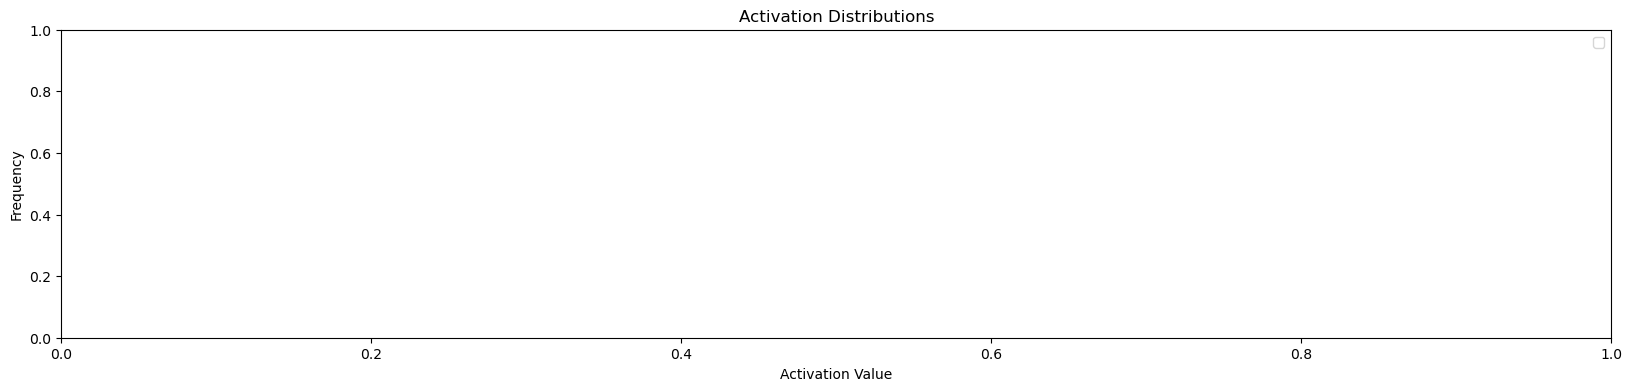

In [20]:
plt.figure(figsize=(20, 4))
legends = []

# Assuming activations_list is a list of dictionaries
for epoch, epoch_activations in enumerate(activations_list):
    print(activations_list)
    for i, (name, tensors) in enumerate(epoch_activations.items()):
        # Combine all tensors for this layer across batches
        all_tensors = torch.cat(tensors, dim=0)

        # Calculate metrics
        zero_percentage = (all_tensors == 0).float().mean().item() * 100
        mean_value = all_tensors.mean().item()
        std_value = all_tensors.std().item()
        sparsity = (all_tensors != 0).float().mean().item() * 100
        variance = all_tensors.var().item()
    
        print(f'Epoch {epoch}, Layer {i} ({name}): mean: {mean_value:+.2f}, std: {std_value:.2f}, zeros: {zero_percentage:.2f}%, sparsity: {sparsity:.2f}%, variance: {variance:.2f}')
     
        # Compute the histogram using numpy
        hist, bin_edges = np.histogram(all_tensors.cpu().numpy().flatten(), bins=50, range=(-2, 2))
        
        # Plot the histogram
        plt.plot(bin_edges[:-1], hist)
        legends.append(f'{name} (Epoch {epoch})')

plt.legend(legends)
plt.title('Activation Distributions')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Assuming 'activations' is a list of (name, tensor) tuples

plt.figure(figsize=(20, 4))
legends = []
for name, t in activations:
    # Calculate metrics
    zero_percentage = (t == 0).float().mean() * 100
    mean_value = t.mean().item()
    std_value = t.std().item()
    sparsity = (t != 0).float().mean() * 100
    variance = t.var().item()

    print(f'{name}: mean: {mean_value:+.2f}, std: {std_value:.2f}, zeros: {zero_percentage:.2f}%, sparsity: {sparsity:.2f}%, variance: {variance:.2f}')
    
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
    legends.append(name)

plt.legend(legends[:3])
plt.title('Activation Distribution')
plt.show()

In [ ]:
# After training, aggregate and visualize activation metrics
plt.figure(figsize=(20, 4))
legends = []

for i, (name, data) in enumerate(activation_metrics.items()):
    all_tensors = torch.cat(data['tensors'], dim=0)
    
    # Calculate metrics
    zero_percentage = (all_tensors == 0).float().mean() * 100
    mean_value = all_tensors.mean().item()
    std_value = all_tensors.std().item()
    sparsity = (all_tensors != 0).float().mean() * 100
    variance = all_tensors.var().item()
    #saturated_percentage = (all_tensors.abs() > 0.97).float().mean() * 100

    print(f'Layer {i} ({name}): mean: {mean_value:+.2f}, std: {std_value:.2f}, zeros: {zero_percentage:.2f}%, sparsity: {sparsity:.2f}%, variance: {variance:.2f}')#, saturated: {saturated_percentage:.2f}%')
    
    hy, hx = torch.histogram(all_tensors, density=True)
    plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
    legends.append(f'Layer {i} ({name})')

plt.legend(legends)
plt.title('Activation Distribution')
plt.show()

# viz gradient distributions

In [ ]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f'{name} grad norm: {param.grad.data.norm(2).item()}')

In [ ]:
# too long print of stats

#viz gradient distributions
#Visualize gradients after training
plt.figure(figsize=(20, 4))
legends = []
for name, grad in gradients:
    #print(f'{name}: mean: {grad.mean():+.2f}, std: {grad.std():.2e}')
    hy, hx = torch.histogram(grad, density=True)
    plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
    legends.append(name)
plt.legend(legends)
plt.title('Gradient Distribution')
plt.show()

# Visualize gradients after training

In [ ]:

plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(net.parameters()):
    if p.grad is not None and p.ndim == 2:
        t = p.grad
        print(f'weight {tuple(p.shape)} | mean {t.mean():+.2f} | std {t.std():.2e} | grad:data ratio {t.std() / p.std():.2e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
        legends.append(f'{i} ({tuple(p.shape)})')
plt.legend(legends)
plt.title('Weight Gradient Distribution')
plt.show()

In [ ]:
#visualize histogram of activations
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i,layer in enumerate(net): #not excluding the last layer since there is no softmax
    if isinstance(layer, ReLU):
        t = layer.out
        print('layer %d (%10s): mean: %+.2f, std: %.2f, saturated: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribation')

In [ ]:
#visualize histogram of gradient
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters): 
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # those ratios should be ~1e-3, indicated on the plot with black         
plt.legend(legends);
plt.title('update to data raio distribation, LR setting')

# load from backup

In [ ]:
# def load_model_from_checkpoint():
#     checkpoint = torch.load('checkpoints/model_epoch_99.pt')

#     net = Network()
#     net.load_state_dict(checkpoint)
#     net.eval()

#     return net

In [ ]:

# def save_checkpoint(net, epoch, checkpoint_dir='checkpoints'):
#     os.makedirs(checkpoint_dir, exist_ok=True)
#     checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
#     torch.save(net.state_dict(), checkpoint_path)
    


In [ ]:
train = True
checkpoint_dir = 'checkpoints'

if train:
    training_result = Train_model()
    model = training_result["net"]
else:
    model = load_latest_checkpoint(checkpoint_dir)

In [ ]:
from IPython.display import Image

plt.plot(training_result[losses])
plt.show()

    